<a target="_blank" href="https://colab.research.google.com/github/moienr/TemporalGAN/blob/main/dataset/Dataset_creator.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [5]:
import sys
IN_COLAB = 'google.colab' in sys.modules
IN_COLAB

True

In [6]:
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
%%capture
if IN_COLAB:
    !pip install geemap
    !pip install geedim

In [8]:
import ee
import geemap
geemap.__version__

'0.20.4'

In [9]:
from datetime import date, datetime
from dateutil.relativedelta import relativedelta
from skimage import io
import numpy as np
import logging
import multiprocessing
import os
import requests
import shutil
# from retry import retry
from datetime import datetime
import matplotlib.pyplot as plt

from collections import namedtuple

In [10]:
import sys
if IN_COLAB:
    sys.path.insert(0, '/content/drive/MyDrive/TemporalGAN-main/dataset')

In [11]:
from utils.utils import *
from utils.ee_utils import *
from utils.ee_utils import TextColors as tc

4/1AfgeXvvmWF-_z0qOvwsZK597gUnHMOdSTjpY6CStI-buWxqNvRlGoRU19og

In [12]:
Map = geemap.Map()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=0cxI-c5XgJCbakgEPvnaZBYAVZka-KgvyhGyh-f1yw0&tc=kaA2sUZ0Ja2Q9s0mBJkk56-rz54joK9pkIAu2jimr4c&cc=LousO6njlxLaRskRaE0wdapZJ4cTwOpJvZkHh3xjXrQ

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AVHEtk5X7fFkg4EpohNhxH-wPKH7Rcsd-IV0popmy1TPPDfWCwKHlEuV0Xk

Successfully saved authorization token.


In [13]:
# ee.Initialize(opt_url='https://earthengine-highvolume.googleapis.com')
ee.Initialize()

# A Function to retrive S1 and S2

has two inputs:
*   date
*   roi


Returns:
*   s1
*   s2 image




In [14]:
from datetime import date, datetime
from dateutil.relativedelta import relativedelta

---

# OSCD Dataset ROIs

### Sentinel 2 Surface Reflectance band 10
band 10 is cirus and is available in TOA data, and is used for atmospheric correction, therfore it is not in the SR img.

# Downlaod All!

In [15]:
import pandas as pd
import ast
import collections
import os
import shutil

In [31]:
YEAR = 2021
Y = YEAR - 2000
if IN_COLAB:
  rois_path = f'/content/drive/MyDrive/TemporalGAN-main/dataset//{Y}_ROIs.xlsx'
else:
  rois_path = f'D:\python\TemporalGAN\dataset\\{Y}_ROIs.xlsx'
SR = False if YEAR == 2017 else True

In [32]:
df = pd.read_excel(rois_path)

## checking if there is a duplicate in the names

In [33]:
names = []
for index, row in df.iterrows():
    names.append(row['name']+str(row['year_type']))
print([item for item, count in collections.Counter(names).items() if count > 1])

[]


Remove unwanted folders in `colab`

In [34]:
#shutil.rmtree('/content/2021')  

In [35]:
# Consice info printing function
sen2_short_print = lambda s2_collection: ee_property_printer(s2_collection, propertie_name_list=['system:time_start','roi_cloud_cover', 'CLOUDY_PIXEL_PERCENTAGE',
                                                                                                            'system:band_names'],
                                                             first_is_t_in_millis=True, df_instead_of_print=False)

sen1_short_print = lambda s2_collection: ee_property_printer(s2_collection, propertie_name_list=['system:time_start','platform_number',
                                                                                           'system:band_names','instrumentMode',                         
                                                                                            'relativeOrbitNumber_stop','relativeOrbitNumber_start',
                                                                                            'cycleNumber'],
                                                             first_is_t_in_millis=True, df_instead_of_print=False)

### dataset downlaoder

In [36]:
if IN_COLAB:
    CURRENT_DIR = '/content/drive/MyDrive/TemporalGAN-main/dataset/s1s2/'
    S1_FOLDER_TRAIN = f'{CURRENT_DIR}{YEAR}/s1_imgs/train/'
    S1_FOLDER_TEST = f'{CURRENT_DIR}{YEAR}/s1_imgs/test/'
    S2_FOLDER_TRAIN = f'{CURRENT_DIR}{YEAR}/s2_imgs/train/'
    S2_FOLDER_TEST = f'{CURRENT_DIR}{YEAR}/s2_imgs/test/'
else:
    S1_FOLDER_TRAIN = f'./s1s2/{YEAR}/s1_imgs/train/'
    S1_FOLDER_TEST = f'./s1s2/{YEAR}/s1_imgs/test/'
    S2_FOLDER_TRAIN = f'./s1s2/{YEAR}/s2_imgs/train/'
    S2_FOLDER_TEST = f'./s1s2/{YEAR}/s2_imgs/test/'
# create folders if not exist
if not os.path.exists(S1_FOLDER_TRAIN) or not os.path.exists(S1_FOLDER_TEST) or not os.path.exists(S2_FOLDER_TRAIN) or not os.path.exists(S2_FOLDER_TEST):
    print("Creating folders...")
    os.makedirs(S1_FOLDER_TRAIN, exist_ok=True)
    os.makedirs(S1_FOLDER_TEST, exist_ok=True)
    os.makedirs(S2_FOLDER_TRAIN, exist_ok=True)
    os.makedirs(S2_FOLDER_TEST, exist_ok=True)
    print('DONE!')

In [37]:
#df = df.iloc[3:]

In [38]:
bands = ['B2','B3','B4','B8','B11','B12']
for index, row in df.iterrows():
    print("🟢",tc.BOLD_BAKGROUNDs.PURPLE,row['name']+str(row['year_type']),tc.ENDC,"🟢")
    r_roi = ast.literal_eval(row['roi'])
    r_roi = ee.Geometry.Polygon(r_roi, None, False)
    r_date = ast.literal_eval(row['date'])
    r_pp =  row['priority_path']
    r_mc =  float(row['max_cloud'])
    r_msn =  float(row['max_snow'])
    r_ms =  int(row['month_span'])
    r_rd =  int(row['retry_days'])

    s2_col,s1_col = s1s2(r_roi , date = r_date , priority_path = r_pp , max_cloud =r_mc , max_snow = r_msn , month_span = r_ms ,retry_days = r_rd , sr = SR)
    s1_col = s1_col.map(toLinear) # convers dB values to Linear, and adds band 'VV_lin' to the images of the collection
    print(tc.OKCYAN,"---------------------------S2---------------------------",tc.ENDC)
    sen2_short_print(s2_col)
    print(tc.OKCYAN,"---------------------------S1---------------------------",tc.ENDC)
    sen1_short_print(s1_col)
    
    #=====================DOWNLOAD==========================
    s1_img = s1_col.mean().clip(r_roi)
    s1_img = toDb(s1_img) # reads the 'VV_lin' and returns the image with the added band 'VV_db' 
    
    if s2_col.size().getInfo()< 3:
        s2_img = s2_col.sort('roi_cloud_cover').first().clip(r_roi).multiply(0.0001)
    else:    
        s2_img = s2_col.median().clip(r_roi).multiply(0.0001)

    s1_img_vv = s1_img.select('VV_db')
    s2_img_12b = s2_img.select(bands)
    
    S1_FOLDER = S1_FOLDER_TRAIN if row['train_test'] == 'train' else S1_FOLDER_TEST
    S2_FOLDER = S2_FOLDER_TRAIN if row['train_test'] == 'train' else S2_FOLDER_TEST
        
    r_name = str(index+1).zfill(3) + '_' + row['name'] + str(row['year_type'])
    geemap.download_ee_image(s1_img_vv, S1_FOLDER +r_name+".tif",crs='EPSG:3857', scale=10,region = r_roi)
    geemap.download_ee_image(s2_img_12b, S2_FOLDER +r_name+".tif",crs='EPSG:3857', scale=10,region = r_roi)

🟢  abudhabi21  🟢
 ◍◍Finding S2 
 ◍Single scene coverege was found! 
 ◍◍Finding S1 
mean s2 date:  2021-06-13
final date range:   2021-05-13 2021-07-13 | diff_days -> 61 
◍checking for DESCENDING single scene
◍DESCENDING singe scene was not fount, checking ASCENDING single scene ...
Mosiac Covers 96.80772245612427 percent of the roi.
Mosaic Coverege Accepted
Mosaic Coverege Accepted
 Low number of images (col_size=5), we will retry:  
  RETRY: Expanding date range by 15 days
 ◍◍Finding S1 
mean s2 date:  2021-06-13
final date range:   2021-05-05 2021-07-21 | diff_days -> 77 
◍checking for DESCENDING single scene
◍DESCENDING singe scene was not fount, checking ASCENDING single scene ...
Mosiac Covers 96.80772245612427 percent of the roi.
Mosaic Coverege Accepted
Mosaic Coverege Accepted
 Low number of images (col_size=6), we will retry:  
  RETRY: Expanding date range by 15 days
 ◍◍Finding S1 
mean s2 date:  2021-06-13
final date range:   2021-04-27 2021-07-29 | diff_days -> 93 
◍checkin

001_abudhabi21.tif: |          | 0.00/6.05M (raw) [  0.0%] in 00:00 (eta:     ?)

001_abudhabi21.tif: |          | 0.00/36.3M (raw) [  0.0%] in 00:00 (eta:     ?)

🟢  abudhabi_buffed21  🟢
 ◍◍Finding S2 
◍No single scene coverge was found!
Mosiac Covers 64.88706164437747 percent of the roi.
Mosaic Coverege Not Accepted
 🔺 Month Range shifted  new range: 2021-07-07 -to- 2021-08-07
 ◍◍Finding S2 
◍No single scene coverge was found!
Mosiac Covers 64.88706164437747 percent of the roi.
Mosaic Coverege Not Accepted
 🔺 Month Range shifted  new range: 2021-08-07 -to- 2021-09-07
 ◍◍Finding S2 
◍No single scene coverge was found!
Mosiac Covers 64.88706164437747 percent of the roi.
Mosaic Coverege Not Accepted
 🔺 Month Range shifted  new range: 2021-09-07 -to- 2021-10-07
 ◍◍Finding S2 
◍No single scene coverge was found!
Collection was empty!
 🔺 Month Range shifted  new range: 2021-10-07 -to- 2021-11-07
 ◍◍Finding S2 
◍No single scene coverge was found!
Mosiac Covers 64.88706164437747 percent of the roi.
Mosaic Coverege Not Accepted
 🔺 Month Range shifted  new range: 2021-11-07 -to- 2021-12-07
 ◍◍Finding S2 
◍No single scene coverge was found!
Mosiac Covers 

002_abudhabi_buffed21.tif: |          | 0.00/39.6M (raw) [  0.0%] in 00:00 (eta:     ?)

002_abudhabi_buffed21.tif: |          | 0.00/237M (raw) [  0.0%] in 00:00 (eta:     ?)

🟢  aguasclaras21  🟢
 ◍◍Finding S2 
 ◍Single scene coverege was found! 
 ◍◍Finding S1 
mean s2 date:  2021-06-26
final date range:   2021-05-26 2021-07-26 | diff_days -> 61 
◍checking for DESCENDING single scene
Mosiac Covers 96.63861773206382 percent of the roi.
Mosaic Coverege Accepted
Mosaic Coverege Accepted
 Low number of images (col_size=5), we will retry:  
  RETRY: Expanding date range by 15 days
 ◍◍Finding S1 
mean s2 date:  2021-06-26
final date range:   2021-05-18 2021-08-03 | diff_days -> 77 
◍checking for DESCENDING single scene
Mosiac Covers 96.63861773206382 percent of the roi.
Mosaic Coverege Accepted
Mosaic Coverege Accepted
 Low number of images (col_size=6), we will retry:  
  RETRY: Expanding date range by 15 days
 ◍◍Finding S1 
mean s2 date:  2021-06-26
final date range:   2021-05-10 2021-08-11 | diff_days -> 93 
◍checking for DESCENDING single scene
Mosiac Covers 96.63861773206382 percent of the roi.
Mosaic Coverege Accepted
Mosaic Coverege Accepted
 ◍Collection Fo

003_aguasclaras21.tif: |          | 0.00/2.16M (raw) [  0.0%] in 00:00 (eta:     ?)

003_aguasclaras21.tif: |          | 0.00/13.0M (raw) [  0.0%] in 00:00 (eta:     ?)

🟢  aguasclaras_buffed21  🟢
 ◍◍Finding S2 
 ◍Single scene coverege was found! 
 ◍◍Finding S1 
mean s2 date:  2021-06-26
final date range:   2021-05-26 2021-07-26 | diff_days -> 61 
◍checking for DESCENDING single scene
Mosiac Covers 98.28746546491728 percent of the roi.
Mosaic Coverege Accepted
Mosaic Coverege Accepted
 Low number of images (col_size=5), we will retry:  
  RETRY: Expanding date range by 15 days
 ◍◍Finding S1 
mean s2 date:  2021-06-26
final date range:   2021-05-18 2021-08-03 | diff_days -> 77 
◍checking for DESCENDING single scene
Mosiac Covers 98.28746546491728 percent of the roi.
Mosaic Coverege Accepted
Mosaic Coverege Accepted
 Low number of images (col_size=6), we will retry:  
  RETRY: Expanding date range by 15 days
 ◍◍Finding S1 
mean s2 date:  2021-06-26
final date range:   2021-05-10 2021-08-11 | diff_days -> 93 
◍checking for DESCENDING single scene
Mosiac Covers 98.28746546491728 percent of the roi.
Mosaic Coverege Accepted
Mosaic Coverege Accepted
 ◍Collec

004_aguasclaras_buffed21.tif: |          | 0.00/36.8M (raw) [  0.0%] in 00:00 (eta:     ?)

004_aguasclaras_buffed21.tif: |          | 0.00/221M (raw) [  0.0%] in 00:00 (eta:     ?)

🟢  aguasclaras_adj_goiania21  🟢
 ◍◍Finding S2 
 ◍Single scene coverege was found! 
 ◍◍Finding S1 
mean s2 date:  2021-06-26
final date range:   2021-05-26 2021-07-26 | diff_days -> 61 
◍checking for DESCENDING single scene
Mosiac Covers 96.21802084167001 percent of the roi.
Mosaic Coverege Accepted
Mosaic Coverege Accepted
 Low number of images (col_size=5), we will retry:  
  RETRY: Expanding date range by 15 days
 ◍◍Finding S1 
mean s2 date:  2021-06-26
final date range:   2021-05-18 2021-08-03 | diff_days -> 77 
◍checking for DESCENDING single scene
Mosiac Covers 96.21802084167001 percent of the roi.
Mosaic Coverege Accepted
Mosaic Coverege Accepted
 Low number of images (col_size=6), we will retry:  
  RETRY: Expanding date range by 15 days
 ◍◍Finding S1 
mean s2 date:  2021-06-26
final date range:   2021-05-10 2021-08-11 | diff_days -> 93 
◍checking for DESCENDING single scene
Mosiac Covers 96.21802084167001 percent of the roi.
Mosaic Coverege Accepted
Mosaic Coverege Accepted
 ◍C

005_aguasclaras_adj_goiania21.tif: |          | 0.00/4.38M (raw) [  0.0%] in 00:00 (eta:     ?)

005_aguasclaras_adj_goiania21.tif: |          | 0.00/26.3M (raw) [  0.0%] in 00:00 (eta:     ?)

🟢  beihai21  🟢
 ◍◍Finding S2 
◍No single scene coverge was found!
Collection was empty!
 🔺 Month Range shifted  new range: 2021-07-07 -to- 2021-08-07
 ◍◍Finding S2 
◍No single scene coverge was found!
Collection was empty!
 🔺 Month Range shifted  new range: 2021-08-07 -to- 2021-09-07
 ◍◍Finding S2 
◍No single scene coverge was found!
Mosiac Covers 8.808329186631845 percent of the roi.
Mosaic Coverege Not Accepted
 🔺 Month Range shifted  new range: 2021-09-07 -to- 2021-10-07
 ◍◍Finding S2 
◍No single scene coverge was found!
Collection was empty!
 🔺 Month Range shifted  new range: 2021-10-07 -to- 2021-11-07
 ◍◍Finding S2 
◍No single scene coverge was found!
Mosiac Covers 8.808329186631845 percent of the roi.
Mosaic Coverege Not Accepted
 🔺 Month Range shifted  new range: 2021-11-07 -to- 2021-12-07
 ◍◍Finding S2 
◍No single scene coverge was found!
Mosiac Covers 8.808329186631845 percent of the roi.
Mosaic Coverege Not Accepted
 🔺 Month Range shifted  new range: 2021-12-07 -to- 2022-01-0

006_beihai21.tif: |          | 0.00/6.49M (raw) [  0.0%] in 00:00 (eta:     ?)

006_beihai21.tif: |          | 0.00/38.9M (raw) [  0.0%] in 00:00 (eta:     ?)

🟢  beihai_buffed21  🟢
 ◍◍Finding S2 
◍No single scene coverge was found!
Collection was empty!
 🔺 Month Range shifted  new range: 2021-07-07 -to- 2021-08-07
 ◍◍Finding S2 
◍No single scene coverge was found!
Mosiac Covers 5.996756346961706 percent of the roi.
Mosaic Coverege Not Accepted
 🔺 Month Range shifted  new range: 2021-08-07 -to- 2021-09-07
 ◍◍Finding S2 
◍No single scene coverge was found!
Collection was empty!
 🔺 Month Range shifted  new range: 2021-09-07 -to- 2021-10-07
 ◍◍Finding S2 
◍No single scene coverge was found!
Collection was empty!
 🔺 Month Range shifted  new range: 2021-10-07 -to- 2021-11-07
 ◍◍Finding S2 
◍No single scene coverge was found!
Mosiac Covers 5.996756346961706 percent of the roi.
Mosaic Coverege Not Accepted
 🔺 Month Range shifted  new range: 2021-11-07 -to- 2021-12-07
 ◍◍Finding S2 
◍No single scene coverge was found!
Mosiac Covers 5.996756346961706 percent of the roi.
Mosaic Coverege Not Accepted
 🔺 Month Range shifted  new range: 2021-12-07 -to- 20

007_beihai_buffed21.tif: |          | 0.00/26.1M (raw) [  0.0%] in 00:00 (eta:     ?)

007_beihai_buffed21.tif: |          | 0.00/157M (raw) [  0.0%] in 00:00 (eta:     ?)

🟢  beirut21  🟢
 ◍◍Finding S2 
 ◍Single scene coverege was found! 
 ◍◍Finding S1 
mean s2 date:  2021-06-21
final date range:   2021-05-21 2021-07-21 | diff_days -> 61 
◍checking for ASCENDING single scene
Mosiac Covers 97.71225737124382 percent of the roi.
Mosaic Coverege Accepted
Mosaic Coverege Accepted
 ◍Collection Found! 
 ---------------------------S2--------------------------- 
Collection Size:  5
system:time_start-------> ['2021-06-09', '2021-06-14', '2021-06-19', '2021-06-29', '2021-07-04']
roi_cloud_cover---------> [0.10024857151100199, 0.16706070641685, 0.09292960582358863, 0.4878804305738403, 0.24602050221467042]
CLOUDY_PIXEL_PERCENTAGE-> [0.275958, 1.813518, 2.441004, 0.490815, 5.437792]
system:band_names-------> [['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'AOT', 'WVP', 'SCL', 'TCI_R', 'TCI_G', 'TCI_B', 'MSK_CLDPRB', 'MSK_SNWPRB', 'QA10', 'QA20', 'QA60'], ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'AOT', 'WVP

008_beirut21.tif: |          | 0.00/14.8M (raw) [  0.0%] in 00:00 (eta:     ?)

008_beirut21.tif: |          | 0.00/88.7M (raw) [  0.0%] in 00:00 (eta:     ?)

🟢  beirut_adj_tripoli21  🟢
 ◍◍Finding S2 
 ◍Single scene coverege was found! 
 ◍◍Finding S1 
mean s2 date:  2021-06-22
final date range:   2021-05-22 2021-07-22 | diff_days -> 61 
◍checking for ASCENDING single scene
Mosiac Covers 97.19462921725031 percent of the roi.
Mosaic Coverege Accepted
Mosaic Coverege Accepted
 ◍Collection Found! 
 ---------------------------S2--------------------------- 
Collection Size:  11
system:time_start-------> ['2021-06-09', '2021-06-14', '2021-06-14', '2021-06-19', '2021-06-19', '2021-06-24', '2021-06-24', '2021-06-29', '2021-06-29', '2021-07-04', '2021-07-04']
roi_cloud_cover---------> [0.4708863694710602, 0.17523664400294822, 0.17729528159554722, 0.3864150193373139, 0.3838271839893645, 0.1048438522248263, 0.10249366310035057, 0.1189224105804507, 0.17282704332260407, 0.27842419524475986, 0.37169122818630895]
CLOUDY_PIXEL_PERCENTAGE-> [4.644875, 5.658737, 1.977668, 6.02845, 4.583548, 0.922164, 0.535678, 1.271197, 0.469434, 15.13345, 12.054575]
system:ba

009_beirut_adj_tripoli21.tif: |          | 0.00/8.20M (raw) [  0.0%] in 00:00 (eta:     ?)

009_beirut_adj_tripoli21.tif: |          | 0.00/49.2M (raw) [  0.0%] in 00:00 (eta:     ?)

🟢  bercy21  🟢
 ◍◍Finding S2 
◍No single scene coverge was found!
Collection was empty!
 🔺 Month Range shifted  new range: 2021-07-07 -to- 2021-08-07
 ◍◍Finding S2 
 ◍Single scene coverege was found! 
 ◍◍Finding S1 
mean s2 date:  2021-07-20
final date range:   2021-06-20 2021-08-20 | diff_days -> 61 
◍checking for DESCENDING single scene
Mosiac Covers 95.00540248471052 percent of the roi.
Mosaic Coverege Accepted
Mosaic Coverege Accepted
 ◍Collection Found! 
 ---------------------------S2--------------------------- 
Collection Size:  2
system:time_start-------> ['2021-07-19', '2021-07-22']
roi_cloud_cover---------> [0.06086427267194157, 0.12172854534388314]
CLOUDY_PIXEL_PERCENTAGE-> [2.355076, 0.408007]
system:band_names-------> [['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'AOT', 'WVP', 'SCL', 'TCI_R', 'TCI_G', 'TCI_B', 'MSK_CLDPRB', 'MSK_SNWPRB', 'QA10', 'QA20', 'QA60'], ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'AOT', 

010_bercy21.tif: |          | 0.00/2.92M (raw) [  0.0%] in 00:00 (eta:     ?)

010_bercy21.tif: |          | 0.00/17.5M (raw) [  0.0%] in 00:00 (eta:     ?)

🟢  bercy_buffed_paris21  🟢
 ◍◍Finding S2 
 ◍Single scene coverege was found! 
 ◍◍Finding S1 
mean s2 date:  2021-06-14
final date range:   2021-05-14 2021-07-14 | diff_days -> 61 
◍checking for DESCENDING single scene
Mosiac Covers 98.17152026284678 percent of the roi.
Mosaic Coverege Accepted
Mosaic Coverege Accepted
 ◍Collection Found! 
 ---------------------------S2--------------------------- 
Collection Size:  1
system:time_start-------> ['2021-06-14']
roi_cloud_cover---------> [0.48774995146573474]
CLOUDY_PIXEL_PERCENTAGE-> [0.329313]
system:band_names-------> [['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'AOT', 'WVP', 'SCL', 'TCI_R', 'TCI_G', 'TCI_B', 'MSK_CLDPRB', 'MSK_SNWPRB', 'QA10', 'QA20', 'QA60']]
 ---------------------------S1--------------------------- 
Collection Size:  10
system:time_start---------> ['2021-05-21', '2021-06-02', '2021-06-14', '2021-06-26', '2021-07-08', '2021-05-15', '2021-05-27', '2021-06-08', '2021-06-20', '2021-07-02']
p

011_bercy_buffed_paris21.tif: |          | 0.00/27.6M (raw) [  0.0%] in 00:00 (eta:     ?)

011_bercy_buffed_paris21.tif: |          | 0.00/165M (raw) [  0.0%] in 00:00 (eta:     ?)

🟢  bordeaux21  🟢
 ◍◍Finding S2 
 ◍Single scene coverege was found! 
 ◍◍Finding S1 
mean s2 date:  2021-06-12
final date range:   2021-05-12 2021-07-12 | diff_days -> 61 
◍checking for DESCENDING single scene
Mosiac Covers 94.96133854775066 percent of the roi.
Mosaic Coverege Accepted
Mosaic Coverege Accepted
 ◍Collection Found! 
 ---------------------------S2--------------------------- 
Collection Size:  1
system:time_start-------> ['2021-06-12']
roi_cloud_cover---------> [0.6786454419166041]
CLOUDY_PIXEL_PERCENTAGE-> [54.073786]
system:band_names-------> [['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'AOT', 'WVP', 'SCL', 'TCI_R', 'TCI_G', 'TCI_B', 'MSK_CLDPRB', 'MSK_SNWPRB', 'QA10', 'QA20', 'QA60']]
 ---------------------------S1--------------------------- 
Collection Size:  10
system:time_start---------> ['2021-05-14', '2021-05-26', '2021-06-07', '2021-06-19', '2021-07-01', '2021-05-20', '2021-06-01', '2021-06-13', '2021-06-25', '2021-07-07']
platform_nu

012_bordeaux21.tif: |          | 0.00/3.95M (raw) [  0.0%] in 00:00 (eta:     ?)

012_bordeaux21.tif: |          | 0.00/23.7M (raw) [  0.0%] in 00:00 (eta:     ?)

🟢  bordeaux_buffed21  🟢
 ◍◍Finding S2 
 ◍Single scene coverege was found! 
 ◍◍Finding S1 
mean s2 date:  2021-06-12
final date range:   2021-05-12 2021-07-12 | diff_days -> 61 
◍checking for DESCENDING single scene
Mosiac Covers 98.12017071969017 percent of the roi.
Mosaic Coverege Accepted
Mosaic Coverege Accepted
 ◍Collection Found! 
 ---------------------------S2--------------------------- 
Collection Size:  1
system:time_start-------> ['2021-06-12']
roi_cloud_cover---------> [0.5445025062456388]
CLOUDY_PIXEL_PERCENTAGE-> [54.073786]
system:band_names-------> [['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'AOT', 'WVP', 'SCL', 'TCI_R', 'TCI_G', 'TCI_B', 'MSK_CLDPRB', 'MSK_SNWPRB', 'QA10', 'QA20', 'QA60']]
 ---------------------------S1--------------------------- 
Collection Size:  10
system:time_start---------> ['2021-05-14', '2021-05-26', '2021-06-07', '2021-06-19', '2021-07-01', '2021-05-20', '2021-06-01', '2021-06-13', '2021-06-25', '2021-07-07']
plat

013_bordeaux_buffed21.tif: |          | 0.00/34.8M (raw) [  0.0%] in 00:00 (eta:     ?)

013_bordeaux_buffed21.tif: |          | 0.00/209M (raw) [  0.0%] in 00:00 (eta:     ?)

🟢  brasilia21  🟢
 ◍◍Finding S2 
 ◍Single scene coverege was found! 
 ◍◍Finding S1 
mean s2 date:  2021-06-23
final date range:   2021-05-23 2021-07-23 | diff_days -> 61 
◍checking for DESCENDING single scene
Mosiac Covers 92.77161985170764 percent of the roi.
Mosaic Coverege Accepted
Mosaic Coverege Accepted
 Low number of images (col_size=5), we will retry:  
  RETRY: Expanding date range by 15 days
 ◍◍Finding S1 
mean s2 date:  2021-06-23
final date range:   2021-05-15 2021-07-31 | diff_days -> 77 
◍checking for DESCENDING single scene
Mosiac Covers 92.77161985170764 percent of the roi.
Mosaic Coverege Accepted
Mosaic Coverege Accepted
 Low number of images (col_size=7), we will retry:  
  RETRY: Expanding date range by 15 days
 ◍◍Finding S1 
mean s2 date:  2021-06-23
final date range:   2021-05-07 2021-08-08 | diff_days -> 93 
◍checking for DESCENDING single scene
Mosiac Covers 92.77161985170764 percent of the roi.
Mosaic Coverege Accepted
Mosaic Coverege Accepted
 ◍Collection Found

014_brasilia21.tif: |          | 0.00/1.77M (raw) [  0.0%] in 00:00 (eta:     ?)

014_brasilia21.tif: |          | 0.00/10.6M (raw) [  0.0%] in 00:00 (eta:     ?)

🟢  brasilia_buffed21  🟢
 ◍◍Finding S2 
 ◍Single scene coverege was found! 
 ◍◍Finding S1 
mean s2 date:  2021-06-23
final date range:   2021-05-23 2021-07-23 | diff_days -> 61 
◍checking for DESCENDING single scene
Mosiac Covers 98.68002743532315 percent of the roi.
Mosaic Coverege Accepted
Mosaic Coverege Accepted
 Low number of images (col_size=5), we will retry:  
  RETRY: Expanding date range by 15 days
 ◍◍Finding S1 
mean s2 date:  2021-06-23
final date range:   2021-05-15 2021-07-31 | diff_days -> 77 
◍checking for DESCENDING single scene
Mosiac Covers 98.68002743532315 percent of the roi.
Mosaic Coverege Accepted
Mosaic Coverege Accepted
 Low number of images (col_size=7), we will retry:  
  RETRY: Expanding date range by 15 days
 ◍◍Finding S1 
mean s2 date:  2021-06-23
final date range:   2021-05-07 2021-08-08 | diff_days -> 93 
◍checking for DESCENDING single scene
Mosiac Covers 98.68002743532315 percent of the roi.
Mosaic Coverege Accepted
Mosaic Coverege Accepted
 ◍Collectio

015_brasilia_buffed21.tif: |          | 0.00/17.3M (raw) [  0.0%] in 00:00 (eta:     ?)

015_brasilia_buffed21.tif: |          | 0.00/104M (raw) [  0.0%] in 00:00 (eta:     ?)

🟢  chongqing21  🟢
 ◍◍Finding S2 
◍No single scene coverge was found!
Collection was empty!
 🔺 Month Range shifted  new range: 2021-06-07 -to- 2021-08-17
 ◍◍Finding S2 
◍No single scene coverge was found!
Collection was empty!
 🔺 Month Range shifted  new range: 2021-07-07 -to- 2021-09-17
 ◍◍Finding S2 
◍No single scene coverge was found!
Collection was empty!
 🔺 Month Range shifted  new range: 2021-08-07 -to- 2021-10-17
 ◍◍Finding S2 
 ◍Single scene coverege was found! 
 ◍◍Finding S1 
mean s2 date:  2021-09-25
final date range:   2021-08-07 2021-11-12 | diff_days -> 97 
◍checking for ASCENDING single scene
Mosiac Covers 94.7070094922932 percent of the roi.
Mosaic Coverege Accepted
Mosaic Coverege Accepted
 ◍Collection Found! 
 ---------------------------S2--------------------------- 
Collection Size:  1
system:time_start-------> ['2021-09-25']
roi_cloud_cover---------> [0.8262454434993926]
CLOUDY_PIXEL_PERCENTAGE-> [3.976818]
system:band_names-------> [['B1', 'B2', 'B3', 'B4', 'B5', 'B6

016_chongqing21.tif: |          | 0.00/4.23M (raw) [  0.0%] in 00:00 (eta:     ?)

016_chongqing21.tif: |          | 0.00/25.4M (raw) [  0.0%] in 00:00 (eta:     ?)

🟢  chongqing_adj21  🟢
 ◍◍Finding S2 
◍No single scene coverge was found!
Collection was empty!
 🔺 Month Range shifted  new range: 2021-06-07 -to- 2021-08-17
 ◍◍Finding S2 
 ◍Single scene coverege was found! 
 ◍◍Finding S1 
mean s2 date:  2021-08-03
final date range:   2021-06-15 2021-09-21 | diff_days -> 98 
◍checking for ASCENDING single scene
Mosiac Covers 99.52777255141429 percent of the roi.
Mosaic Coverege Accepted
Mosaic Coverege Accepted
 ◍Collection Found! 
 ---------------------------S2--------------------------- 
Collection Size:  2
system:time_start-------> ['2021-08-01', '2021-08-06']
roi_cloud_cover---------> [1.298237488115843, 0.709738101622746]
CLOUDY_PIXEL_PERCENTAGE-> [1.376954, 3.866115]
system:band_names-------> [['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'AOT', 'WVP', 'SCL', 'TCI_R', 'TCI_G', 'TCI_B', 'MSK_CLDPRB', 'MSK_SNWPRB', 'QA10', 'QA20', 'QA60'], ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'AOT

017_chongqing_adj21.tif: |          | 0.00/61.0M (raw) [  0.0%] in 00:00 (eta:     ?)

017_chongqing_adj21.tif: |          | 0.00/366M (raw) [  0.0%] in 00:00 (eta:     ?)

🟢  cupertino21  🟢
 ◍◍Finding S2 
◍No single scene coverge was found!
Collection was empty!
 🔺 Month Range shifted  new range: 2021-07-07 -to- 2021-08-07
 ◍◍Finding S2 
 ◍Single scene coverege was found! 
 ◍◍Finding S1 
mean s2 date:  2021-07-19
final date range:   2021-06-19 2021-08-19 | diff_days -> 61 
◍checking for DESCENDING single scene
Mosiac Covers 98.31643240205472 percent of the roi.
Mosaic Coverege Accepted
Mosaic Coverege Accepted
 ◍Collection Found! 
 ---------------------------S2--------------------------- 
Collection Size:  5
system:time_start-------> ['2021-07-08', '2021-07-13', '2021-07-18', '2021-07-23', '2021-08-02']
roi_cloud_cover---------> [0.38748109235347894, 0.36961964945749376, 0.32487252680969847, 0.05961607249314415, 0]
CLOUDY_PIXEL_PERCENTAGE-> [43.910228, 59.315655, 45.149094, 42.981349, 15.258698]
system:band_names-------> [['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'AOT', 'WVP', 'SCL', 'TCI_R', 'TCI_G', 'TCI_B', 'MSK_CLDPR

018_cupertino21.tif: |          | 0.00/10.4M (raw) [  0.0%] in 00:00 (eta:     ?)

018_cupertino21.tif: |          | 0.00/62.4M (raw) [  0.0%] in 00:00 (eta:     ?)

🟢  cupertino_buffed21  🟢
 ◍◍Finding S2 
◍No single scene coverge was found!
Mosiac Covers 13.109032208505452 percent of the roi.
Mosaic Coverege Not Accepted
 🔺 Month Range shifted  new range: 2021-07-07 -to- 2021-08-07
 ◍◍Finding S2 
 ◍Single scene coverege was found! 
 ◍◍Finding S1 
mean s2 date:  2021-07-19
final date range:   2021-06-19 2021-08-19 | diff_days -> 61 
◍checking for DESCENDING single scene
Mosiac Covers 98.70002740681713 percent of the roi.
Mosaic Coverege Accepted
Mosaic Coverege Accepted
 ◍Collection Found! 
 ---------------------------S2--------------------------- 
Collection Size:  5
system:time_start-------> ['2021-07-08', '2021-07-13', '2021-07-18', '2021-07-23', '2021-08-02']
roi_cloud_cover---------> [1.29240472268345, 1.2391246803306841, 1.0771625396783726, 0.42837329063054425, 0.9831157722488749]
CLOUDY_PIXEL_PERCENTAGE-> [43.910228, 59.315655, 45.149094, 42.981349, 15.258698]
system:band_names-------> [['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A',

019_cupertino_buffed21.tif: |          | 0.00/45.1M (raw) [  0.0%] in 00:00 (eta:     ?)

019_cupertino_buffed21.tif: |          | 0.00/271M (raw) [  0.0%] in 00:00 (eta:     ?)

🟢  cupertino_adj_losangles21  🟢
 ◍◍Finding S2 
 ◍Single scene coverege was found! 
 ◍◍Finding S1 
mean s2 date:  2021-06-27
final date range:   2021-05-27 2021-07-27 | diff_days -> 61 
◍checking for DESCENDING single scene
Mosiac Covers 99.7262358362303 percent of the roi.
Mosaic Coverege Accepted
Mosaic Coverege Accepted
 ◍Collection Found! 
 ---------------------------S2--------------------------- 
Collection Size:  1
system:time_start-------> ['2021-06-27']
roi_cloud_cover---------> [0.46372855957828263]
CLOUDY_PIXEL_PERCENTAGE-> [52.564917]
system:band_names-------> [['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'AOT', 'WVP', 'SCL', 'TCI_R', 'TCI_G', 'TCI_B', 'MSK_CLDPRB', 'MSK_SNWPRB', 'QA10', 'QA20', 'QA60']]
 ---------------------------S1--------------------------- 
Collection Size:  10
system:time_start---------> ['2021-05-30', '2021-06-11', '2021-06-23', '2021-07-05', '2021-07-17', '2021-06-05', '2021-06-17', '2021-06-29', '2021-07-11', '2021-07-2

020_cupertino_adj_losangles21.tif: |          | 0.00/57.5M (raw) [  0.0%] in 00:00 (eta:     ?)

020_cupertino_adj_losangles21.tif: |          | 0.00/345M (raw) [  0.0%] in 00:00 (eta:     ?)

🟢  dubai21  🟢
 ◍◍Finding S2 
 ◍Single scene coverege was found! 
 ◍◍Finding S1 
mean s2 date:  2021-07-02
final date range:   2021-05-15 2021-08-20 | diff_days -> 97 
◍checking for DESCENDING single scene
Mosiac Covers 95.9508884885926 percent of the roi.
Mosaic Coverege Accepted
Mosaic Coverege Accepted
 ◍Collection Found! 
 ---------------------------S2--------------------------- 
Collection Size:  1
system:time_start-------> ['2021-07-02']
roi_cloud_cover---------> [0.019770660340055358]
CLOUDY_PIXEL_PERCENTAGE-> [1.087634]
system:band_names-------> [['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'AOT', 'WVP', 'SCL', 'TCI_R', 'TCI_G', 'TCI_B', 'MSK_CLDPRB', 'MSK_SNWPRB', 'QA10', 'QA20', 'QA60']]
 ---------------------------S1--------------------------- 
Collection Size:  8
system:time_start---------> ['2021-05-25', '2021-06-06', '2021-06-18', '2021-06-30', '2021-07-12', '2021-07-24', '2021-08-05', '2021-08-17']
platform_number-----------> ['A', 'A', 'A',

021_dubai21.tif: |          | 0.00/4.83M (raw) [  0.0%] in 00:00 (eta:     ?)

021_dubai21.tif: |          | 0.00/29.0M (raw) [  0.0%] in 00:00 (eta:     ?)

🟢  dubai_buffed21  🟢
 ◍◍Finding S2 
◍No single scene coverge was found!
Collection was empty!
 🔺 Month Range shifted  new range: 2021-06-07 -to- 2021-08-07
 ◍◍Finding S2 
◍No single scene coverge was found!
Collection was empty!
 🔺 Month Range shifted  new range: 2021-07-07 -to- 2021-09-07
 ◍◍Finding S2 
 ◍Single scene coverege was found! 
 ◍◍Finding S1 
mean s2 date:  2021-08-26
final date range:   2021-07-08 2021-10-14 | diff_days -> 98 
◍checking for DESCENDING single scene
Mosiac Covers 98.86637206863 percent of the roi.
Mosaic Coverege Accepted
Mosaic Coverege Accepted
 ◍Collection Found! 
 ---------------------------S2--------------------------- 
Collection Size:  1
system:time_start-------> ['2021-08-26']
roi_cloud_cover---------> [0.9746389908260541]
CLOUDY_PIXEL_PERCENTAGE-> [0.346927]
system:band_names-------> [['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'AOT', 'WVP', 'SCL', 'TCI_R', 'TCI_G', 'TCI_B', 'MSK_CLDPRB', 'MSK_SNWPRB', 'QA10', 'QA20',

022_dubai_buffed21.tif: |          | 0.00/47.7M (raw) [  0.0%] in 00:00 (eta:     ?)

022_dubai_buffed21.tif: |          | 0.00/286M (raw) [  0.0%] in 00:00 (eta:     ?)

🟢  dubai_adj_sharje21  🟢
 ◍◍Finding S2 
 ◍Single scene coverege was found! 
 ◍◍Finding S1 
mean s2 date:  2021-07-02
final date range:   2021-05-15 2021-08-20 | diff_days -> 97 
◍checking for DESCENDING single scene
Mosiac Covers 99.0088945010207 percent of the roi.
Mosaic Coverege Accepted
Mosaic Coverege Accepted
 ◍Collection Found! 
 ---------------------------S2--------------------------- 
Collection Size:  1
system:time_start-------> ['2021-07-02']
roi_cloud_cover---------> [0.8934942984938019]
CLOUDY_PIXEL_PERCENTAGE-> [1.087634]
system:band_names-------> [['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'AOT', 'WVP', 'SCL', 'TCI_R', 'TCI_G', 'TCI_B', 'MSK_CLDPRB', 'MSK_SNWPRB', 'QA10', 'QA20', 'QA60']]
 ---------------------------S1--------------------------- 
Collection Size:  8
system:time_start---------> ['2021-05-25', '2021-06-06', '2021-06-18', '2021-06-30', '2021-07-12', '2021-07-24', '2021-08-05', '2021-08-17']
platform_number-----------> ['A', 

023_dubai_adj_sharje21.tif: |          | 0.00/36.3M (raw) [  0.0%] in 00:00 (eta:     ?)

023_dubai_adj_sharje21.tif: |          | 0.00/218M (raw) [  0.0%] in 00:00 (eta:     ?)

🟢  hongkong21  🟢
 ◍◍Finding S2 
◍No single scene coverge was found!
Collection was empty!
 🔺 Month Range shifted  new range: 2021-09-07 -to- 2021-10-07
 ◍◍Finding S2 
◍No single scene coverge was found!
Collection was empty!
 🔺 Month Range shifted  new range: 2021-10-07 -to- 2021-11-07
 ◍◍Finding S2 
◍No single scene coverge was found!
Collection was empty!
 🔺 Month Range shifted  new range: 2021-11-07 -to- 2021-12-07
 ◍◍Finding S2 
◍No single scene coverge was found!
Collection was empty!
 🔺 Month Range shifted  new range: 2021-12-07 -to- 2022-01-07
 ◍◍Finding S2 
◍No single scene coverge was found!
Collection was empty!
 🔺 Month Range shifted  new range: 2022-01-07 -to- 2022-02-07
 ◍◍Finding S2 
◍No single scene coverge was found!
Collection was empty!
 🔺 Month Range shifted  new range: 2022-02-07 -to- 2022-03-07
 ◍◍Finding S2 
 ◍Single scene coverege was found! 
 ◍◍Finding S1 
mean s2 date:  2022-03-03
final date range:   2022-02-03 2022-04-03 | diff_days -> 59 
◍checking for ASCEND

024_hongkong21.tif: |          | 0.00/3.52M (raw) [  0.0%] in 00:00 (eta:     ?)

024_hongkong21.tif: |          | 0.00/21.1M (raw) [  0.0%] in 00:00 (eta:     ?)

🟢  hongkong_adj21  🟢
 ◍◍Finding S2 
◍No single scene coverge was found!
Collection was empty!
 🔺 Month Range shifted  new range: 2021-09-07 -to- 2021-10-07
 ◍◍Finding S2 
◍No single scene coverge was found!
Collection was empty!
 🔺 Month Range shifted  new range: 2021-10-07 -to- 2021-11-07
 ◍◍Finding S2 
◍No single scene coverge was found!
Collection was empty!
 🔺 Month Range shifted  new range: 2021-11-07 -to- 2021-12-07
 ◍◍Finding S2 
◍No single scene coverge was found!
Collection was empty!
 🔺 Month Range shifted  new range: 2021-12-07 -to- 2022-01-07
 ◍◍Finding S2 
◍No single scene coverge was found!
Collection was empty!
 🔺 Month Range shifted  new range: 2022-01-07 -to- 2022-02-07
 ◍◍Finding S2 
◍No single scene coverge was found!
Collection was empty!
 🔺 Month Range shifted  new range: 2022-02-07 -to- 2022-03-07
 ◍◍Finding S2 
◍No single scene coverge was found!
Collection was empty!
 🔺 Month Range shifted  new range: 2022-03-07 -to- 2022-04-07
 ◍◍Finding S2 
 ◍Single scene cove

025_hongkong_adj21.tif: |          | 0.00/10.2M (raw) [  0.0%] in 00:00 (eta:     ?)

025_hongkong_adj21.tif: |          | 0.00/61.1M (raw) [  0.0%] in 00:00 (eta:     ?)

🟢  lasvegas21  🟢
 ◍◍Finding S2 
◍No single scene coverge was found!
Mosiac Covers 25.855520558804795 percent of the roi.
Mosaic Coverege Not Accepted
 🔺 Month Range shifted  new range: 2021-07-07 -to- 2021-08-07
 ◍◍Finding S2 
 ◍Single scene coverege was found! 
 ◍◍Finding S1 
mean s2 date:  2021-07-14
final date range:   2021-06-14 2021-08-14 | diff_days -> 61 
◍checking for DESCENDING single scene
Mosiac Covers 97.03680800345789 percent of the roi.
Mosaic Coverege Accepted
Mosaic Coverege Accepted
 ◍Collection Found! 
 ---------------------------S2--------------------------- 
Collection Size:  1
system:time_start-------> ['2021-07-14']
roi_cloud_cover---------> [0.016412276382734285]
CLOUDY_PIXEL_PERCENTAGE-> [0.566538]
system:band_names-------> [['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'AOT', 'WVP', 'SCL', 'TCI_R', 'TCI_G', 'TCI_B', 'MSK_CLDPRB', 'MSK_SNWPRB', 'QA10', 'QA20', 'QA60']]
 ---------------------------S1--------------------------- 
Colle

026_lasvegas21.tif: |          | 0.00/7.31M (raw) [  0.0%] in 00:00 (eta:     ?)

026_lasvegas21.tif: |          | 0.00/43.8M (raw) [  0.0%] in 00:00 (eta:     ?)

🟢  lasvegas_buffed21  🟢
 ◍◍Finding S2 
◍No single scene coverge was found!
Mosiac Covers 73.2616060723675 percent of the roi.
Mosaic Coverege Not Accepted
 🔺 Month Range shifted  new range: 2021-07-07 -to- 2021-08-07
 ◍◍Finding S2 
◍No single scene coverge was found!
Mosiac Covers 98.85668112523018 percent of the roi.
Mosaic Coverege Accepted
 ◍Image Mosaic found in date range of 2021-07-07 to 2021-08-07 
 ◍◍Finding S1 
mean s2 date:  2021-07-28
final date range:   2021-06-28 2021-08-28 | diff_days -> 61 
◍checking for DESCENDING single scene
Mosiac Covers 98.85668112523018 percent of the roi.
Mosaic Coverege Accepted
Mosaic Coverege Accepted
 ◍Collection Found! 
 ---------------------------S2--------------------------- 
Collection Size:  3
system:time_start-------> ['2021-07-14', '2021-08-03', '2021-08-03']
roi_cloud_cover---------> [0.03335742480680491, 0.4121226641794982, 0.42190601709077463]
CLOUDY_PIXEL_PERCENTAGE-> [0.566538, 6.837426, 1.354504]
system:band_names-------> [['B1', 

027_lasvegas_buffed21.tif: |          | 0.00/68.1M (raw) [  0.0%] in 00:00 (eta:     ?)

027_lasvegas_buffed21.tif: |          | 0.00/409M (raw) [  0.0%] in 00:00 (eta:     ?)

🟢  milano21  🟢
 ◍◍Finding S2 
 ◍Single scene coverege was found! 
 ◍◍Finding S1 
mean s2 date:  2021-07-15
final date range:   2021-06-15 2021-08-15 | diff_days -> 61 
◍checking for DESCENDING single scene
Mosiac Covers 97.08391097505815 percent of the roi.
Mosaic Coverege Accepted
Mosaic Coverege Accepted
 ◍Collection Found! 
 ---------------------------S2--------------------------- 
Collection Size:  2
system:time_start-------> ['2021-07-10', '2021-07-20']
roi_cloud_cover---------> [0.23603471239241966, 0.06091989034419738]
CLOUDY_PIXEL_PERCENTAGE-> [4.014307, 5.597744]
system:band_names-------> [['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'AOT', 'WVP', 'SCL', 'TCI_R', 'TCI_G', 'TCI_B', 'MSK_CLDPRB', 'MSK_SNWPRB', 'QA10', 'QA20', 'QA60'], ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'AOT', 'WVP', 'SCL', 'TCI_R', 'TCI_G', 'TCI_B', 'MSK_CLDPRB', 'MSK_SNWPRB', 'QA10', 'QA20', 'QA60']]
 ---------------------------S1----------

028_milano21.tif: |          | 0.00/5.26M (raw) [  0.0%] in 00:00 (eta:     ?)

028_milano21.tif: |          | 0.00/31.6M (raw) [  0.0%] in 00:00 (eta:     ?)

🟢  milano_buffed21  🟢
 ◍◍Finding S2 
 ◍Single scene coverege was found! 
 ◍◍Finding S1 
mean s2 date:  2021-07-20
final date range:   2021-06-20 2021-08-20 | diff_days -> 61 
◍checking for DESCENDING single scene
Mosiac Covers 99.05129504274652 percent of the roi.
Mosaic Coverege Accepted
Mosaic Coverege Accepted
 ◍Collection Found! 
 ---------------------------S2--------------------------- 
Collection Size:  1
system:time_start-------> ['2021-07-20']
roi_cloud_cover---------> [0.17582952298566484]
CLOUDY_PIXEL_PERCENTAGE-> [5.597744]
system:band_names-------> [['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'AOT', 'WVP', 'SCL', 'TCI_R', 'TCI_G', 'TCI_B', 'MSK_CLDPRB', 'MSK_SNWPRB', 'QA10', 'QA20', 'QA60']]
 ---------------------------S1--------------------------- 
Collection Size:  10
system:time_start---------> ['2021-06-30', '2021-07-12', '2021-07-24', '2021-08-05', '2021-08-17', '2021-06-24', '2021-07-06', '2021-07-18', '2021-07-30', '2021-08-11']
platfo

029_milano_buffed21.tif: |          | 0.00/49.3M (raw) [  0.0%] in 00:00 (eta:     ?)

029_milano_buffed21.tif: |          | 0.00/296M (raw) [  0.0%] in 00:00 (eta:     ?)

🟢  montpellier21  🟢
 ◍◍Finding S2 
 ◍Single scene coverege was found! 
 ◍◍Finding S1 
mean s2 date:  2021-06-24
final date range:   2021-05-24 2021-07-24 | diff_days -> 61 
◍checking for DESCENDING single scene
Mosiac Covers 96.179610882976 percent of the roi.
Mosaic Coverege Accepted
Mosaic Coverege Accepted
 ◍Collection Found! 
 ---------------------------S2--------------------------- 
Collection Size:  3
system:time_start-------> ['2021-06-16', '2021-06-26', '2021-07-01']
roi_cloud_cover---------> [0.480750439710768, 0, 0]
CLOUDY_PIXEL_PERCENTAGE-> [9.020166, 12.945379, 3.470324]
system:band_names-------> [['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'AOT', 'WVP', 'SCL', 'TCI_R', 'TCI_G', 'TCI_B', 'MSK_CLDPRB', 'MSK_SNWPRB', 'QA10', 'QA20', 'QA60'], ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'AOT', 'WVP', 'SCL', 'TCI_R', 'TCI_G', 'TCI_B', 'MSK_CLDPRB', 'MSK_SNWPRB', 'QA10', 'QA20', 'QA60'], ['B1', 'B2', 'B3', 'B4', 'B5'

030_montpellier21.tif: |          | 0.00/3.08M (raw) [  0.0%] in 00:00 (eta:     ?)

030_montpellier21.tif: |          | 0.00/18.5M (raw) [  0.0%] in 00:00 (eta:     ?)

🟢  montpellier_buffed21  🟢
 ◍◍Finding S2 
 ◍Single scene coverege was found! 
 ◍◍Finding S1 
mean s2 date:  2021-06-28
final date range:   2021-05-28 2021-07-28 | diff_days -> 61 
◍checking for DESCENDING single scene
Mosiac Covers 98.33362489320162 percent of the roi.
Mosaic Coverege Accepted
Mosaic Coverege Accepted
 ◍Collection Found! 
 ---------------------------S2--------------------------- 
Collection Size:  2
system:time_start-------> ['2021-06-26', '2021-07-01']
roi_cloud_cover---------> [0.09546575775945222, 0.09910672415962302]
CLOUDY_PIXEL_PERCENTAGE-> [12.945379, 3.470324]
system:band_names-------> [['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'AOT', 'WVP', 'SCL', 'TCI_R', 'TCI_G', 'TCI_B', 'MSK_CLDPRB', 'MSK_SNWPRB', 'QA10', 'QA20', 'QA60'], ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'AOT', 'WVP', 'SCL', 'TCI_R', 'TCI_G', 'TCI_B', 'MSK_CLDPRB', 'MSK_SNWPRB', 'QA10', 'QA20', 'QA60']]
 --------------------------

031_montpellier_buffed21.tif: |          | 0.00/31.0M (raw) [  0.0%] in 00:00 (eta:     ?)

031_montpellier_buffed21.tif: |          | 0.00/186M (raw) [  0.0%] in 00:00 (eta:     ?)

🟢  mumbai21  🟢
 ◍◍Finding S2 
◍No single scene coverge was found!
Collection was empty!
 🔺 Month Range shifted  new range: 2021-09-07 -to- 2021-10-07
 ◍◍Finding S2 
◍No single scene coverge was found!
Collection was empty!
 🔺 Month Range shifted  new range: 2021-10-07 -to- 2021-11-07
 ◍◍Finding S2 
 ◍Single scene coverege was found! 
 ◍◍Finding S1 
mean s2 date:  2021-10-25
final date range:   2021-09-25 2021-11-25 | diff_days -> 61 
◍checking for DESCENDING single scene
Mosiac Covers 96.20493709603028 percent of the roi.
Mosaic Coverege Accepted
Mosaic Coverege Accepted
 Low number of images (col_size=6), we will retry:  
  RETRY: Expanding date range by 15 days
 ◍◍Finding S1 
mean s2 date:  2021-10-25
final date range:   2021-09-17 2021-12-03 | diff_days -> 77 
◍checking for DESCENDING single scene
Mosiac Covers 96.20493709603028 percent of the roi.
Mosaic Coverege Accepted
Mosaic Coverege Accepted
 Low number of images (col_size=6), we will retry:  
  RETRY: Expanding date range by 

032_mumbai21.tif: |          | 0.00/4.33M (raw) [  0.0%] in 00:00 (eta:     ?)

032_mumbai21.tif: |          | 0.00/26.0M (raw) [  0.0%] in 00:00 (eta:     ?)

🟢  mumbai_buffed21  🟢
 ◍◍Finding S2 
◍No single scene coverge was found!
Collection was empty!
 🔺 Month Range shifted  new range: 2021-08-01 -to- 2021-10-07
 ◍◍Finding S2 
◍No single scene coverge was found!
Collection was empty!
 🔺 Month Range shifted  new range: 2021-09-01 -to- 2021-11-07
 ◍◍Finding S2 
 ◍Single scene coverege was found! 
 ◍◍Finding S1 
mean s2 date:  2021-10-31
final date range:   2021-09-30 2021-11-30 | diff_days -> 61 
◍checking for DESCENDING single scene
Mosiac Covers 98.68593683205219 percent of the roi.
Mosaic Coverege Accepted
Mosaic Coverege Accepted
 Low number of images (col_size=5), we will retry:  
  RETRY: Expanding date range by 15 days
 ◍◍Finding S1 
mean s2 date:  2021-10-31
final date range:   2021-09-22 2021-12-08 | diff_days -> 77 
◍checking for DESCENDING single scene
Mosiac Covers 98.68593683205219 percent of the roi.
Mosaic Coverege Accepted
Mosaic Coverege Accepted
 Low number of images (col_size=7), we will retry:  
  RETRY: Expanding date ra

033_mumbai_buffed21.tif: |          | 0.00/32.9M (raw) [  0.0%] in 00:00 (eta:     ?)

033_mumbai_buffed21.tif: |          | 0.00/197M (raw) [  0.0%] in 00:00 (eta:     ?)

🟢  nantes21  🟢
 ◍◍Finding S2 
 ◍Single scene coverege was found! 
 ◍◍Finding S1 
mean s2 date:  2021-06-13
final date range:   2021-05-13 2021-07-13 | diff_days -> 61 
◍checking for DESCENDING single scene
Mosiac Covers 97.28408673958027 percent of the roi.
Mosaic Coverege Accepted
Mosaic Coverege Accepted
 ◍Collection Found! 
 ---------------------------S2--------------------------- 
Collection Size:  2
system:time_start-------> ['2021-06-12', '2021-06-15']
roi_cloud_cover---------> [0.24009603841536614, 0.12004801920768307]
CLOUDY_PIXEL_PERCENTAGE-> [3.506914, 4.732423]
system:band_names-------> [['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'AOT', 'WVP', 'SCL', 'TCI_R', 'TCI_G', 'TCI_B', 'MSK_CLDPRB', 'MSK_SNWPRB', 'QA10', 'QA20', 'QA60'], ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'AOT', 'WVP', 'SCL', 'TCI_R', 'TCI_G', 'TCI_B', 'MSK_CLDPRB', 'MSK_SNWPRB', 'QA10', 'QA20', 'QA60']]
 ---------------------------S1----------

034_nantes21.tif: |          | 0.00/5.58M (raw) [  0.0%] in 00:00 (eta:     ?)

034_nantes21.tif: |          | 0.00/33.5M (raw) [  0.0%] in 00:00 (eta:     ?)

🟢  nantes_buffed21  🟢
 ◍◍Finding S2 
◍No single scene coverge was found!
Mosiac Covers 98.88062923965309 percent of the roi.
Mosaic Coverege Accepted
 ◍Image Mosaic found in date range of 2021-06-07 to 2021-07-07 
 ◍◍Finding S1 
mean s2 date:  2021-06-13
final date range:   2021-05-13 2021-07-13 | diff_days -> 61 
◍checking for DESCENDING single scene
Mosiac Covers 98.88062923965309 percent of the roi.
Mosaic Coverege Accepted
Mosaic Coverege Accepted
 ◍Collection Found! 
 ---------------------------S2--------------------------- 
Collection Size:  4
system:time_start-------> ['2021-06-12', '2021-06-12', '2021-06-15', '2021-06-15']
roi_cloud_cover---------> [0.17727045068885353, 0.16324134033271642, 0.0571864277544796, 0.07255458083239892]
CLOUDY_PIXEL_PERCENTAGE-> [1.585801, 3.506914, 2.556179, 4.732423]
system:band_names-------> [['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'AOT', 'WVP', 'SCL', 'TCI_R', 'TCI_G', 'TCI_B', 'MSK_CLDPRB', 'MSK_SNWPRB', 'QA10

035_nantes_buffed21.tif: |          | 0.00/66.5M (raw) [  0.0%] in 00:00 (eta:     ?)

035_nantes_buffed21.tif: |          | 0.00/399M (raw) [  0.0%] in 00:00 (eta:     ?)

🟢  norcia21  🟢
 ◍◍Finding S2 
 ◍Single scene coverege was found! 
 ◍◍Finding S1 
mean s2 date:  2021-05-23
final date range:   2021-04-23 2021-06-23 | diff_days -> 61 
◍checking for DESCENDING single scene
Mosiac Covers 91.36185447010298 percent of the roi.
Mosaic Coverege Accepted
Mosaic Coverege Accepted
 ◍Collection Found! 
 ---------------------------S2--------------------------- 
Collection Size:  3
system:time_start-------> ['2021-05-10', '2021-05-25', '2021-06-04']
roi_cloud_cover---------> [0.28735632183908044, 0, 0]
CLOUDY_PIXEL_PERCENTAGE-> [0.878362, 10.331605, 12.200503]
system:band_names-------> [['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'AOT', 'WVP', 'SCL', 'TCI_R', 'TCI_G', 'TCI_B', 'MSK_CLDPRB', 'MSK_SNWPRB', 'QA10', 'QA20', 'QA60'], ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'AOT', 'WVP', 'SCL', 'TCI_R', 'TCI_G', 'TCI_B', 'MSK_CLDPRB', 'MSK_SNWPRB', 'QA10', 'QA20', 'QA60'], ['B1', 'B2', 'B3', 'B4', 'B5'

036_norcia21.tif: |          | 0.00/1.48M (raw) [  0.0%] in 00:00 (eta:     ?)

036_norcia21.tif: |          | 0.00/8.86M (raw) [  0.0%] in 00:00 (eta:     ?)

🟢  paris21  🟢
 ◍◍Finding S2 
 ◍Single scene coverege was found! 
 ◍◍Finding S1 
mean s2 date:  2021-06-14
final date range:   2021-05-14 2021-07-14 | diff_days -> 61 
◍checking for DESCENDING single scene
Mosiac Covers 93.96914404374861 percent of the roi.
Mosaic Coverege Accepted
Mosaic Coverege Accepted
 ◍Collection Found! 
 ---------------------------S2--------------------------- 
Collection Size:  1
system:time_start-------> ['2021-06-14']
roi_cloud_cover---------> [0.05373455131649651]
CLOUDY_PIXEL_PERCENTAGE-> [0.329313]
system:band_names-------> [['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'AOT', 'WVP', 'SCL', 'TCI_R', 'TCI_G', 'TCI_B', 'MSK_CLDPRB', 'MSK_SNWPRB', 'QA10', 'QA20', 'QA60']]
 ---------------------------S1--------------------------- 
Collection Size:  10
system:time_start---------> ['2021-05-21', '2021-06-02', '2021-06-14', '2021-06-26', '2021-07-08', '2021-05-15', '2021-05-27', '2021-06-08', '2021-06-20', '2021-07-02']
platform_numbe

037_paris21.tif: |          | 0.00/3.25M (raw) [  0.0%] in 00:00 (eta:     ?)

037_paris21.tif: |          | 0.00/19.5M (raw) [  0.0%] in 00:00 (eta:     ?)

🟢  paris_buffed21  🟢
 ◍◍Finding S2 
◍No single scene coverge was found!
Collection was empty!
 🔺 Month Range shifted  new range: 2021-06-07 -to- 2021-08-07
 ◍◍Finding S2 
 ◍Single scene coverege was found! 
 ◍◍Finding S1 
mean s2 date:  2021-07-20
final date range:   2021-06-20 2021-08-20 | diff_days -> 61 
◍checking for DESCENDING single scene
Mosiac Covers 98.31037598339734 percent of the roi.
Mosaic Coverege Accepted
Mosaic Coverege Accepted
 ◍Collection Found! 
 ---------------------------S2--------------------------- 
Collection Size:  2
system:time_start-------> ['2021-07-19', '2021-07-22']
roi_cloud_cover---------> [0.6594036697247707, 0.6266382699868938]
CLOUDY_PIXEL_PERCENTAGE-> [2.355076, 0.408007]
system:band_names-------> [['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'AOT', 'WVP', 'SCL', 'TCI_R', 'TCI_G', 'TCI_B', 'MSK_CLDPRB', 'MSK_SNWPRB', 'QA10', 'QA20', 'QA60'], ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'A

038_paris_buffed21.tif: |          | 0.00/44.4M (raw) [  0.0%] in 00:00 (eta:     ?)

038_paris_buffed21.tif: |          | 0.00/267M (raw) [  0.0%] in 00:00 (eta:     ?)

🟢  pisa21  🟢
 ◍◍Finding S2 
 ◍Single scene coverege was found! 
 ◍◍Finding S1 
mean s2 date:  2021-06-16
final date range:   2021-05-16 2021-07-16 | diff_days -> 61 
◍checking for DESCENDING single scene
Mosiac Covers 97.09290153325104 percent of the roi.
Mosaic Coverege Accepted
Mosaic Coverege Accepted
 ◍Collection Found! 
 ---------------------------S2--------------------------- 
Collection Size:  5
system:time_start-------> ['2021-05-26', '2021-06-12', '2021-06-17', '2021-06-25', '2021-07-02']
roi_cloud_cover---------> [0.7437457741717377, 0.5243341420408596, 0.5875724190961037, 0.6329793580718291, 0.8622678280237045]
CLOUDY_PIXEL_PERCENTAGE-> [3.666325, 7.055237, 5.16727, 16.305168, 14.292794]
system:band_names-------> [['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'AOT', 'WVP', 'SCL', 'TCI_R', 'TCI_G', 'TCI_B', 'MSK_CLDPRB', 'MSK_SNWPRB', 'QA10', 'QA20', 'QA60'], ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'AOT', 'WVP'

039_pisa21.tif: |          | 0.00/8.86M (raw) [  0.0%] in 00:00 (eta:     ?)

039_pisa21.tif: |          | 0.00/53.2M (raw) [  0.0%] in 00:00 (eta:     ?)

🟢  rennes21  🟢
 ◍◍Finding S2 
 ◍Single scene coverege was found! 
 ◍◍Finding S1 
mean s2 date:  2021-06-15
final date range:   2021-05-15 2021-07-15 | diff_days -> 61 
◍checking for DESCENDING single scene
Mosiac Covers 96.26008308577603 percent of the roi.
Mosaic Coverege Accepted
Mosaic Coverege Accepted
 ◍Collection Found! 
 ---------------------------S2--------------------------- 
Collection Size:  1
system:time_start-------> ['2021-06-15']
roi_cloud_cover---------> [0.1400560224089636]
CLOUDY_PIXEL_PERCENTAGE-> [6.306037]
system:band_names-------> [['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'AOT', 'WVP', 'SCL', 'TCI_R', 'TCI_G', 'TCI_B', 'MSK_CLDPRB', 'MSK_SNWPRB', 'QA10', 'QA20', 'QA60']]
 ---------------------------S1--------------------------- 
Collection Size:  10
system:time_start---------> ['2021-05-19', '2021-05-31', '2021-06-12', '2021-06-24', '2021-07-06', '2021-05-25', '2021-06-06', '2021-06-18', '2021-06-30', '2021-07-12']
platform_numbe

040_rennes21.tif: |          | 0.00/3.71M (raw) [  0.0%] in 00:00 (eta:     ?)

040_rennes21.tif: |          | 0.00/22.2M (raw) [  0.0%] in 00:00 (eta:     ?)

🟢  rio21  🟢
 ◍◍Finding S2 
 ◍Single scene coverege was found! 
 ◍◍Finding S1 
mean s2 date:  2021-04-25
final date range:   2021-03-25 2021-05-25 | diff_days -> 61 
◍checking for DESCENDING single scene
Mosiac Covers 92.25437853591148 percent of the roi.
Mosaic Coverege Accepted
Mosaic Coverege Accepted
 Low number of images (col_size=5), we will retry:  
  RETRY: Expanding date range by 15 days
 ◍◍Finding S1 
mean s2 date:  2021-04-25
final date range:   2021-03-17 2021-06-02 | diff_days -> 77 
◍checking for DESCENDING single scene
Mosiac Covers 92.25437853591148 percent of the roi.
Mosaic Coverege Accepted
Mosaic Coverege Accepted
 Low number of images (col_size=7), we will retry:  
  RETRY: Expanding date range by 15 days
 ◍◍Finding S1 
mean s2 date:  2021-04-25
final date range:   2021-03-09 2021-06-10 | diff_days -> 93 
◍checking for DESCENDING single scene
Mosiac Covers 92.25437853591148 percent of the roi.
Mosaic Coverege Accepted
Mosaic Coverege Accepted
 Low number of images (

041_rio21.tif: |          | 0.00/1.44M (raw) [  0.0%] in 00:00 (eta:     ?)

041_rio21.tif: |          | 0.00/8.64M (raw) [  0.0%] in 00:00 (eta:     ?)

🟢  saclay_w21  🟢
 ◍◍Finding S2 
 ◍Single scene coverege was found! 
 ◍◍Finding S1 
mean s2 date:  2021-06-12
final date range:   2021-05-12 2021-07-12 | diff_days -> 61 
◍checking for DESCENDING single scene
Mosiac Covers 96.29941772261772 percent of the roi.
Mosaic Coverege Accepted
Mosaic Coverege Accepted
 ◍Collection Found! 
 ---------------------------S2--------------------------- 
Collection Size:  3
system:time_start-------> ['2021-06-09', '2021-06-14', '2021-06-14']
roi_cloud_cover---------> [0.4914472993808474, 0.5537325676784249, 0.4528612597776863]
CLOUDY_PIXEL_PERCENTAGE-> [12.530479, 0.198549, 0.329313]
system:band_names-------> [['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'AOT', 'WVP', 'SCL', 'TCI_R', 'TCI_G', 'TCI_B', 'MSK_CLDPRB', 'MSK_SNWPRB', 'QA10', 'QA20', 'QA60'], ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'AOT', 'WVP', 'SCL', 'TCI_R', 'TCI_G', 'TCI_B', 'MSK_CLDPRB', 'MSK_SNWPRB', 'QA10', 'QA20', 'QA6

042_saclay_w21.tif: |          | 0.00/8.74M (raw) [  0.0%] in 00:00 (eta:     ?)

042_saclay_w21.tif: |          | 0.00/52.4M (raw) [  0.0%] in 00:00 (eta:     ?)

🟢  saclay_e21  🟢
 ◍◍Finding S2 
 ◍Single scene coverege was found! 
 ◍◍Finding S1 
mean s2 date:  2021-06-14
final date range:   2021-05-14 2021-07-14 | diff_days -> 61 
◍checking for DESCENDING single scene
Mosiac Covers 96.29565725882945 percent of the roi.
Mosaic Coverege Accepted
Mosaic Coverege Accepted
 ◍Collection Found! 
 ---------------------------S2--------------------------- 
Collection Size:  2
system:time_start-------> ['2021-06-14', '2021-06-14']
roi_cloud_cover---------> [0.3039235739294695, 0.22282185045271932]
CLOUDY_PIXEL_PERCENTAGE-> [0.198549, 0.329313]
system:band_names-------> [['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'AOT', 'WVP', 'SCL', 'TCI_R', 'TCI_G', 'TCI_B', 'MSK_CLDPRB', 'MSK_SNWPRB', 'QA10', 'QA20', 'QA60'], ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'AOT', 'WVP', 'SCL', 'TCI_R', 'TCI_G', 'TCI_B', 'MSK_CLDPRB', 'MSK_SNWPRB', 'QA10', 'QA20', 'QA60']]
 ---------------------------S1---------

043_saclay_e21.tif: |          | 0.00/8.74M (raw) [  0.0%] in 00:00 (eta:     ?)

043_saclay_e21.tif: |          | 0.00/52.4M (raw) [  0.0%] in 00:00 (eta:     ?)

🟢  valencia21  🟢
 ◍◍Finding S2 
 ◍Single scene coverege was found! 
 ◍◍Finding S1 
mean s2 date:  2021-06-24
final date range:   2021-05-24 2021-07-24 | diff_days -> 61 
◍checking for DESCENDING single scene
Mosiac Covers 94.93481324590844 percent of the roi.
Mosaic Coverege Accepted
Mosaic Coverege Accepted
 ◍Collection Found! 
 ---------------------------S2--------------------------- 
Collection Size:  7
system:time_start-------> ['2021-06-14', '2021-06-14', '2021-06-24', '2021-06-24', '2021-06-29', '2021-06-29', '2021-07-04']
roi_cloud_cover---------> [0.3491924923614142, 0.3491924923614142, 0.4195445092048168, 0.49931102951874773, 0.221155245162229, 0.2810657217928638, 0.043649061545176775]
CLOUDY_PIXEL_PERCENTAGE-> [1.693392, 6.483605, 1.162757, 0.861301, 11.109426, 11.579056, 12.057475]
system:band_names-------> [['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'AOT', 'WVP', 'SCL', 'TCI_R', 'TCI_G', 'TCI_B', 'MSK_CLDPRB', 'MSK_SNWPRB', 'QA10', 'QA20', '

044_valencia21.tif: |          | 0.00/2.97M (raw) [  0.0%] in 00:00 (eta:     ?)

044_valencia21.tif: |          | 0.00/17.8M (raw) [  0.0%] in 00:00 (eta:     ?)

🟢  valencia_buffed21  🟢
 ◍◍Finding S2 
 ◍Single scene coverege was found! 
 ◍◍Finding S1 
mean s2 date:  2021-06-20
final date range:   2021-05-20 2021-07-20 | diff_days -> 61 
◍checking for DESCENDING single scene
Mosiac Covers 98.85507878646625 percent of the roi.
Mosaic Coverege Accepted
Mosaic Coverege Accepted
 Low number of images (col_size=5), we will retry:  
  RETRY: Expanding date range by 15 days
 ◍◍Finding S1 
mean s2 date:  2021-06-20
final date range:   2021-05-12 2021-07-28 | diff_days -> 77 
◍checking for DESCENDING single scene
Mosiac Covers 98.85507878646625 percent of the roi.
Mosaic Coverege Accepted
Mosaic Coverege Accepted
 Low number of images (col_size=7), we will retry:  
  RETRY: Expanding date range by 15 days
 ◍◍Finding S1 
mean s2 date:  2021-06-20
final date range:   2021-05-04 2021-08-05 | diff_days -> 93 
◍checking for DESCENDING single scene
Mosiac Covers 98.85507878646625 percent of the roi.
Mosaic Coverege Accepted
Mosaic Coverege Accepted
 Low number

045_valencia_buffed21.tif: |          | 0.00/48.3M (raw) [  0.0%] in 00:00 (eta:     ?)

045_valencia_buffed21.tif: |          | 0.00/290M (raw) [  0.0%] in 00:00 (eta:     ?)

In [39]:
if IN_COLAB:
    ! du -sh /content/drive/MyDrive/TemporalGAN-main/dataset/s1s2/2021
    ! du -sh /content/drive/MyDrive/TemporalGAN-main/dataset/s1s2/2019
    ! du -sh /content/drive/MyDrive/TemporalGAN-main/dataset/s1s2/2017

2.7G	/content/drive/MyDrive/TemporalGAN-main/dataset/s1s2/2021
2.7G	/content/drive/MyDrive/TemporalGAN-main/dataset/s1s2/2019
2.7G	/content/drive/MyDrive/TemporalGAN-main/dataset/s1s2/2017


In [40]:
(count_files("/content/drive/MyDrive/TemporalGAN-main/dataset/s1s2/2021"),
count_files("/content/drive/MyDrive/TemporalGAN-main/dataset/s1s2/2019"),
count_files("/content/drive/MyDrive/TemporalGAN-main/dataset/s1s2/2017"))

(90, 90, 90)

## Saving downloaded dataset for later use in drive

In [ ]:
# from distutils.dir_util import copy_tree
# copy_tree("/content/s1_imgs", "/content/drive/MyDrive/Colab Notebooks/rgb2sar/dataset/s1")
# copy_tree("/content/s2_imgs", "/content/drive/MyDrive/Colab Notebooks/rgb2sar/dataset/s2")

# patching the files

## importing patch function
`perfect_patchify` is what I worte on my own.

we also install and import `patchify` library

In [41]:
import sys
if IN_COLAB:
    from utils.utils import perfect_patchify  

##loading the data from drive to working directory

In [ ]:
# from distutils.dir_util import copy_tree
# copy_tree("/content/drive/MyDrive/Colab Notebooks/rgb2sar/dataset/s1","/content/s1_imgs")
# copy_tree("/content/drive/MyDrive/Colab Notebooks/rgb2sar/dataset/s2","/content/s2_imgs")

In [42]:
from skimage import io


## patchify s2 images

In [ ]:
# shutil.rmtree('/content/s2_imgs_patched//')

In [43]:
years = [2017, 2019, 2021]

for year in years:
    print("\n",f"🟥🟩🟨YEAR: {year}")

    print("\n",f"🟩🟩🟩TRAIN...","\n")
    in_path = f'/content/drive/MyDrive/TemporalGAN-main/dataset/s1s2/{year}/s2_imgs/train/'
    patch_folder(in_path = in_path, out_path = in_path.replace('s1s2', 's1s2_patched'), input_sat = 'S2')
    print("\n",f"🟨🟨🟨TEST...","\n")
    in_path = f'/content/drive/MyDrive/TemporalGAN-main/dataset/s1s2/{year}/s2_imgs/test/'
    patch_folder(in_path = in_path, out_path = in_path.replace('s1s2', 's1s2_patched'), input_sat = 'S2')



 🟥🟩🟨YEAR: 2017

 🟩🟩🟩TRAIN... 

 001_abudhabi17.tif 
shape after fix: (919, 823, 6)
range before norm:  nan nan nan nan
NaN Ratio: 0.0002644323892656316 Percent
range after norm and NaN removal:   0.01 0.3288270494171249 0.08074432989829507 0.78315 
extreme mode activated!
extreme mode activated!
✅  Final Shape-> (4, 4, 256, 256, 6) 
 002_abudhabi_buffed17.tif 
shape after fix: (1797, 2753, 6)
range before norm:  0.061500000000000006 0.3001139051204862 0.08446739316882515 1.27345
NaN Ratio: 0.0 Percent
range after norm and NaN removal:   0.061500000000000006 0.30011358096187946 0.08446445299949437 0.99 
✅  Final Shape-> (7, 12, 256, 256, 6) 
 003_aguasclaras17.tif 
shape after fix: (502, 538, 6)
range before norm:  0.01745 0.15599421511599199 0.06717612465519428 1.915
NaN Ratio: 0.0 Percent
range after norm and NaN removal:   0.01745 0.15599270365872317 0.06715022540052859 0.99 
✅  Final Shape-> (2, 2, 256, 256, 6) 
 004_aguasclaras_buffed17.tif 
shape after fix: (1377, 3345, 6)
range 

In [44]:
if IN_COLAB:
    ! du -sh /content/drive/MyDrive/TemporalGAN-main/dataset/s1s2_patched/

18G	/content/drive/MyDrive/TemporalGAN-main/dataset/s1s2_patched/


In [45]:
years = [2017, 2019, 2021]

for year in years:
    print("\n",f"🟥🟩🟨YEAR: {year}")

    print("\n",f"🟩🟩🟩TRAIN...","\n")
    in_path = f'/content/drive/MyDrive/TemporalGAN-main/dataset/s1s2/{year}/s1_imgs/train/'
    patch_folder(in_path = in_path, out_path = in_path.replace('s1s2', 's1s2_patched'), input_sat = 'S1')
    print("\n",f"🟨🟨🟨TEST...","\n")
    in_path = f'/content/drive/MyDrive/TemporalGAN-main/dataset/s1s2/{year}/s1_imgs/test/'
    patch_folder(in_path = in_path, out_path = in_path.replace('s1s2', 's1s2_patched'), input_sat = 'S1')


 🟥🟩🟨YEAR: 2017

 🟩🟩🟩TRAIN... 

 001_abudhabi17.tif 
shape after fix: (919, 823, 1)
range before norm:  nan nan nan nan
NaN Ratio: 0.0002644323892656316 Percent
range after norm and NaN removal:   -24.878608782419622 -12.54747567793777 4.951391548476838 15.0 
extreme mode activated!
extreme mode activated!
✅  Final Shape-> (4, 4, 256, 256, 1) 
 002_abudhabi_buffed17.tif 
shape after fix: (1797, 2753, 1)
range before norm:  -25.46481531291844 -11.908457881354945 6.209457362589691 35.60059872592968
NaN Ratio: 0.0 Percent
range after norm and NaN removal:   -25.0 -11.9214085204175 6.144285415408558 15.0 
✅  Final Shape-> (7, 12, 256, 256, 1) 
 003_aguasclaras17.tif 
shape after fix: (502, 538, 1)
range before norm:  -21.50772186410932 -8.43999393163425 3.748052063147131 23.50928341628609
NaN Ratio: 0.0 Percent
range after norm and NaN removal:   -21.50772186410932 -8.441111862673667 3.740470754476217 15.0 
✅  Final Shape-> (2, 2, 256, 256, 1) 
 004_aguasclaras_buffed17.tif 
shape after fi

In [46]:
if IN_COLAB:
    ! du -sh /content/drive/MyDrive/TemporalGAN-main/dataset/s1s2_patched/

21G	/content/drive/MyDrive/TemporalGAN-main/dataset/s1s2_patched/


In [47]:
[
    count_files("/content/drive/MyDrive/TemporalGAN-main/dataset/s1s2_patched/2017"),
    count_files("/content/drive/MyDrive/TemporalGAN-main/dataset/s1s2_patched/2019"),
    count_files("/content/drive/MyDrive/TemporalGAN-main/dataset/s1s2_patched/2021"),
]

[4006, 4006, 4006]

In [ ]:
import os

# def rename_tif_files(path):
#     for subdir, dirs, files in os.walk(path):
#         for file in files:
#                 file_path = os.path.join(subdir, file)
#                 file_name = file

#                 start_name = file_name[:-10]
#                 end_name = file_name[-8:]
#                 new_name  = start_name + end_name + ".tif" 

#                 os.rename(file_path, os.path.join(subdir, new_name))

# rename_tif_files("/content/drive/MyDrive/TemporalGAN-main/dataset/s1s2_patched")

## Randomly plotting an image

In [16]:
import random
from skimage import io

In [85]:
import matplotlib.pyplot as plt
import math

def plot_sample_images(images, columns = 3):
    """
    Plots a list of images with a specified number of columns.
    """
    rows = math.ceil(len(images) / columns)
    fig, ax = plt.subplots(nrows=rows, ncols=columns, figsize=(columns*4, rows*4))
    for i, image in enumerate(images):
        row = i // columns
        col = i % columns
        if rows == 1:
            ax[col].imshow(image)
            ax[col].axis('off')
        else:
            ax[row, col].imshow(image)
            ax[row, col].axis('off')
    plt.show()

In [95]:
tt = random.choice(['train','test']) # randomly choosing between train and test
years = [2021,2019,2017]
s2_path = f"/content/drive/MyDrive/TemporalGAN-main/dataset/s1s2_patched/{2021}/s2_imgs/{tt}//" # choosing a random file from 2021
files = os.listdir(s2_path)
files.sort()
# only keep the tif files
files = [f for f in files if f.endswith(".tif") or f.endswith(".tiff")] 
file_name = random.choice(files)

In [96]:
s2_imgs = []
s1_imgs = []
# picking all the images with name file name from all the years
for year in years:
    s2_imgs.append(f"/content/drive/MyDrive/TemporalGAN-main/dataset/s1s2_patched/{year}/s2_imgs/{tt}//{file_name}")
    s1_imgs.append(f"/content/drive/MyDrive/TemporalGAN-main/dataset/s1s2_patched/{year}/s1_imgs/{tt}//{file_name}")
print([s2_img.split("/")[-1] for s2_img in s2_imgs],"\n",[s1_img.split('/')[-1] for s1_img in s1_imgs])
s2_imgs = [reshape_array(io.imread(path),channel_first=False) for path in s2_imgs]
s2_imgs_rgb = [img[:,:,[2,1,0]] for img in s2_imgs]
s1_imgs = [io.imread(path) for path in s1_imgs]

['011_bercy_buffed_paris_r03_c04.tif', '011_bercy_buffed_paris_r03_c04.tif', '011_bercy_buffed_paris_r03_c04.tif'] 
 ['011_bercy_buffed_paris_r03_c04.tif', '011_bercy_buffed_paris_r03_c04.tif', '011_bercy_buffed_paris_r03_c04.tif']


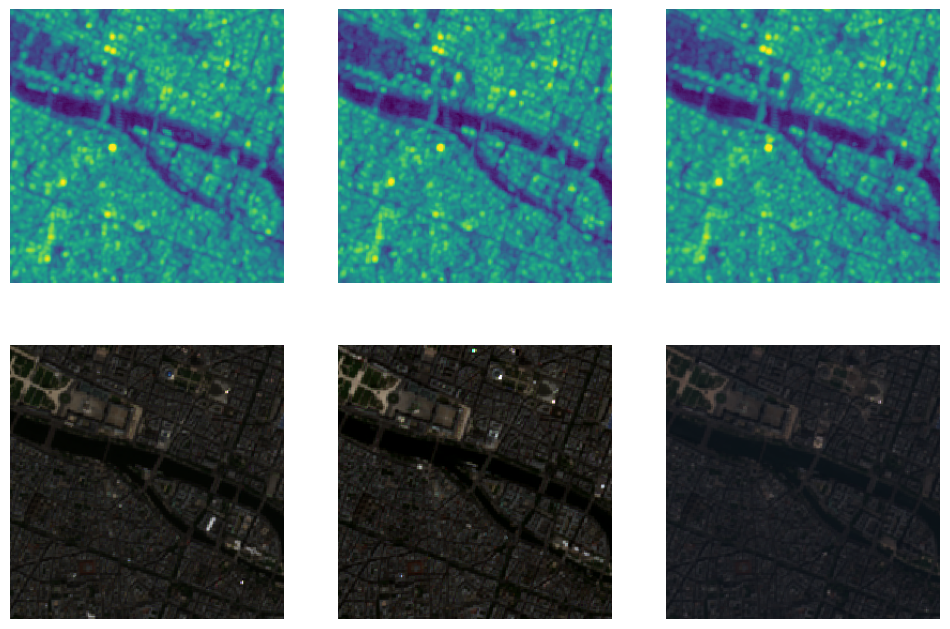

In [97]:
plot_sample_images(s1_imgs+s2_imgs_rgb)

## converting the patched folders into zip files

In [98]:
!zip -r '/content/drive/MyDrive/s1s2_patched.zip' '/content/drive/MyDrive/TemporalGAN-main/dataset/s1s2_patched'

Streaming output truncated to the last 5000 lines.
  adding: content/drive/MyDrive/TemporalGAN-main/dataset/s1s2_patched/2019/s1_imgs/train/002_abudhabi_buffed_r00_c02.tif (deflated 6%)
  adding: content/drive/MyDrive/TemporalGAN-main/dataset/s1s2_patched/2019/s1_imgs/train/002_abudhabi_buffed_r00_c03.tif (deflated 6%)
  adding: content/drive/MyDrive/TemporalGAN-main/dataset/s1s2_patched/2019/s1_imgs/train/002_abudhabi_buffed_r00_c04.tif (deflated 6%)
  adding: content/drive/MyDrive/TemporalGAN-main/dataset/s1s2_patched/2019/s1_imgs/train/002_abudhabi_buffed_r00_c05.tif (deflated 6%)
  adding: content/drive/MyDrive/TemporalGAN-main/dataset/s1s2_patched/2019/s1_imgs/train/002_abudhabi_buffed_r00_c06.tif (deflated 5%)
  adding: content/drive/MyDrive/TemporalGAN-main/dataset/s1s2_patched/2019/s1_imgs/train/002_abudhabi_buffed_r00_c07.tif (deflated 6%)
  adding: content/drive/MyDrive/TemporalGAN-main/dataset/s1s2_patched/2019/s1_imgs/train/002_abudhabi_buffed_r00_c08.tif (deflated 6%)
  ad

In [101]:
! du -sh /content/drive/MyDrive/s1s2.zip
! du -sh /content/drive/MyDrive/s1s2_patched.zip

6.6G	/content/drive/MyDrive/s1s2.zip
5.8G	/content/drive/MyDrive/s1s2_patched.zip


In [ ]:
# from IPython.display import FileLink
# FileLink(r's1s2.zip')

In [ ]:
# !cp "/content/s1s2.zip" "/content/drive/MyDrive"

In [ ]:
# os.listdir("/content/drive/MyDrive")

['.config', 'TemporalGAN-main', 's1s2.zip']